In [97]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold

In [57]:
df = pd.read_csv("https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv")

In [58]:
df.columns = df.columns.str.lower()

In [59]:
status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}

df.status = df.status.map(status_values)


home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

In [60]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=0)

In [61]:
df = df[df.status != 'unk'].reset_index(drop=True)

In [62]:
df['default'] = (df.status == 'default').astype(int)
del df['status']

In [63]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [64]:
len(df_train), len(df_val), len(df_test)

(2672, 891, 891)

In [65]:
df_full_train.head()

,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price,default
1034,5,private,60,24,married,no,fixed,45,127,2000,0,1000,1282,0
3955,14,parents,60,32,married,yes,fixed,35,140,0,0,1150,1273,0
398,25,owner,12,43,married,no,freelance,75,250,100000,0,600,841,0
3994,18,rent,60,37,married,no,fixed,70,100,0,0,1300,1345,0
1355,1,parents,48,24,single,yes,fixed,35,65,0,0,900,1061,1


In [120]:
 numerical = list(df_train.dtypes[df_train.dtypes == 'int'].index)

In [121]:
feature_numerical = numerical.copy()

In [122]:
feature_numerical.remove("default")

In [123]:
for feature in feature_numerical:
    score = round(roc_auc_score(df_train['default'], df_train[feature]),3)
    if abs(score)<0.5:
        score = -score
    print('%s, %f'%(feature,score))

seniority, -0.298000
time, 0.561000
age, -0.433000
expenses, 0.501000
income, -0.313000
assets, -0.365000
debt, -0.499000
amount, 0.588000
price, -0.486000


In [124]:
base = ['seniority', 'income', 'assets', 'records', 'job', 'home']

In [125]:
y_train = df_train['default']

In [126]:
y_val = df_val['default']

In [127]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[base].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[base].to_dict(orient='records')
X_val = dv.transform(val_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

In [128]:
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [129]:
y_pred = model.predict_proba(X_val)[:, 1]

In [130]:
round(roc_auc_score(y_val, y_pred),3)

0.805

In [131]:
thresholds = np.linspace(0, 1, 100)
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)
recall = []
precision = []
F_value = []
for t in thresholds:
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)
    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    p = tp / (tp + fp)
    r = tp / (tp + fn)
    f = 2 * ((p*r)/(p+r))
    precision.append(p)
    recall.append(r)
    F_value.append(f)

<ipython-input-131-22bfb305c21e>:15: RuntimeWarning: invalid value encountered in long_scalars
  p = tp / (tp + fp)


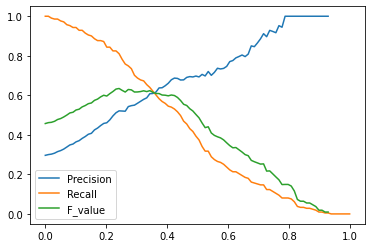

In [132]:
plt.plot(thresholds, precision, label='Precision')
plt.plot(thresholds, recall , label='Recall')
plt.plot(thresholds, F_value , label='F_value')
plt.legend()

In [157]:
n_splits = 5

kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train['default']
    y_val = df_val['default']

    dv, model = train(df_train, y_train, C=1.0)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)
print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

0.812 +- 0.014


In [169]:

def train(df_train, y_train, C=1.0):
    dicts = df_train[base].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear',C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [170]:
def predict(df, dv, model):
    dicts = df[base].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred


In [171]:
n_splits = 5

for C in [0.01, 0.1, 1, 10]:
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train['default']
        y_val = df_val['default']

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))    

C=0.01 0.809 +- 0.013
C=0.1 0.813 +- 0.014
C=1 0.812 +- 0.014
C=10 0.814 +- 0.015
